In [1]:
%matplotlib inline
import open_ply as op
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [62]:
# read .ply mesh
pathDesktop = 'C:/Users/cdelettre/Desktop/'

subj = 'F10_P8'
path = 'E:/Celine/Ferret_b2n/'+subj+'/'

In [63]:
# read the set of endpoints

fendpoints = path+subj+'_endpoints.txt'
endpoints = np.loadtxt(fendpoints)

In [64]:
divx = 4
divy = 4
divz = 4

In [65]:
fmesh = path+subj+'_mesh.ply'
mesh = op.open_ply(fmesh)
npt=mesh["np"];
nt=mesh["nt"];
pt=mesh["p"];
t=mesh["t"];

In [66]:
#use the mesh support for the grid
xmax= max(pt[:,0])
xmin= min(pt[:,0])
ymax= max(pt[:,1])
ymin= min(pt[:,1])
zmax= max(pt[:,2])
zmin= min(pt[:,2])

dx = (xmax-xmin)/divx
dy = (ymax-ymin)/divy
dz = (zmax-zmin)/divz

In [67]:
#use endpoints for the grid
xmax= max(endpoints[:,0])
xmin= min(endpoints[:,0])
ymax= max(endpoints[:,1])
ymin= min(endpoints[:,1])
zmax= max(endpoints[:,2])
zmin= min(endpoints[:,2])

dx = (xmax-xmin)/divx
dy = (ymax-ymin)/divy
dz = (zmax-zmin)/divz

In [68]:
cubenb = divx * divy * divz
grid = np.zeros((cubenb,6))

In [69]:
index = 0
for k in range(divz):
    for j in range(divy):
        for i in range(divx):
            x = xmin+dx/2+i*dx
            y = ymin+dy/2+j*dy
            z = zmin+dz/2+k*dz
            grid[index] = [x,y,z,dx,dy,dz]  #coords of center of square and delta to the edges
            index += 1

In [71]:
order = 2 # 0: order x ie front/back // 1: order y ie right/left // 2: order z ie top/down
ind = np.zeros(cubenb)
if order == 0:
    ind = np.lexsort((grid[:,2],grid[:,1],grid[:,0]))
elif order == 1:
    ind = np.lexsort((grid[:,2],grid[:,0],grid[:,1]))
elif order == 2:
    ind = np.lexsort((grid[:,0],grid[:,1],grid[:,2]))
    
gridreordered= grid[ind]
#print order
#print gridreordered[:,0]

In [72]:
def isPointinCube(p,cube):
    cx = cube[0]
    cy = cube[1]
    cz = cube[2]
    dx = cube[3]
    dy = cube[4]
    dz = cube[5]
    
    if cx-dx/2<=p[0] and p[0]<cx+dx/2 and cy-dy/2<=p[1] and p[1]<cy+dy/2 and cz-dz/2<=p[2] and p[2]<cz+dz/2 :
        return True
    else: 
        return False

In [73]:
tab = np.zeros((len(endpoints),2)).astype(int) #cube id, endpoint id
conMat = np.zeros((cubenb,cubenb))

for i in range(len(endpoints)):
    ep = endpoints[i]
    for j in range(cubenb):
        c = gridreordered[j]
        if isPointinCube(ep,c):
            #print 'ep',i,'is in cube',c[0]
            tab[i] = [j,i]
            if i%2 == 1:
                conMat[tab[i-1,0],j]+=1
                conMat[j,tab[i-1,0]]+=1
            break
        tab[i] = [-1,i] #out of cubes
            

C:\Users\cdelettre\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


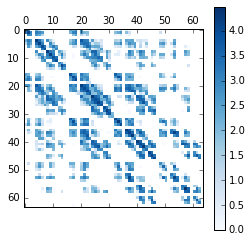

In [91]:

plt.matshow(np.log10(conMat),interpolation='nearest',cmap=plt.cm.Blues)
#plt.xticks(range(8),xorder)
#plt.yticks(range(8),xorder)
plt.colorbar()
plt.savefig(path+subj+'_grid'+str(order)+'_'+str(divx)+str(divy)+str(divz)+'_log10.png')
plt.show()

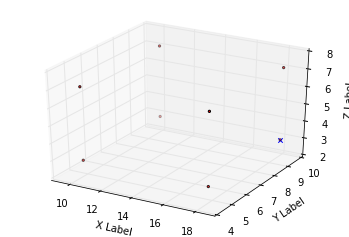

In [125]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = 0
y = 1
z = 2
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
gridn = 3
ax.scatter(gridreordered[gridn,x],gridreordered[gridn,y],gridreordered[gridn,z],c='b',marker='x')
#ax.scatter(pt[:,x],pt[:,y],pt[:,z],c='y',marker='+')
#ax.scatter(endpoints[0:10000,x],endpoints[0:10000,y],endpoints[0:10000,z],c='g',marker='+')
#ax.scatter(endpoints[:,x],endpoints[:,y],endpoints[:,z],c='g',marker='+',alpha=0.002)
ax.scatter(grid[:,x], grid[:,y], grid[:,z],c='r',marker='.')

In [71]:
len(endpoints)

2347088

In [74]:
highdegnodes = conMat.sum(axis=1,dtype=int)

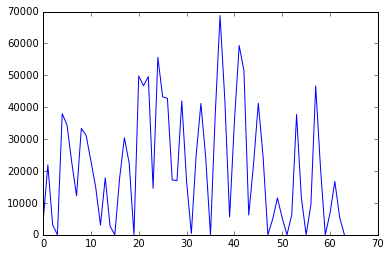

In [85]:
plt.plot(highdegnodes)

In [82]:
hdngrid = np.empty(gridreordered.shape[0],dtype=int)
hdngrid[:]=-1
i=0
for ind, val in enumerate(highdegnodes):
    if val>=max(highdegnodes)*0.75:
        hdngrid[i]=ind
        #print val, ind
        i+=1

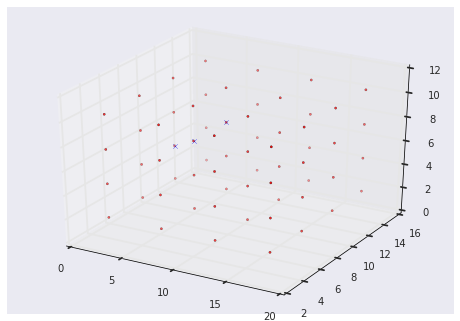

In [115]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111, projection='3d')
x = 0
y = 1
z = 2
for i in hdngrid:
    if i >=0:
        ax.scatter(gridreordered[i,x],gridreordered[i,y],gridreordered[i,z],c='b',marker='x')
ax.scatter(grid[:,x], grid[:,y], grid[:,z],c='r',marker='.')

plt.savefig(path+subj+'_grid'+str(order)+'_'+str(divx)+str(divy)+str(divz)+'_highdegreenodes.png')

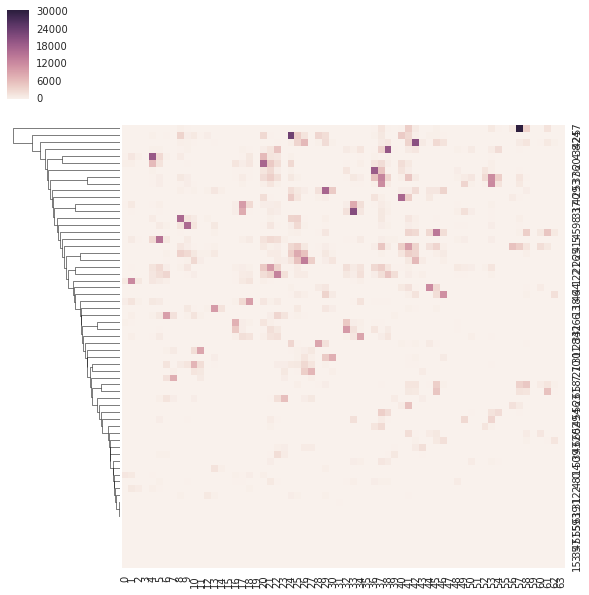

In [109]:
import seaborn as sn
sn.clustermap(conMat,col_cluster=False)
sn.plt.savefig(path+subj+'_grid'+str(order)+'_'+str(divx)+str(divy)+str(divz)+'_clustermap.png')

In [87]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z= linkage(conMat,'ward')

In [88]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(conMat))
c

0.84365880870799415

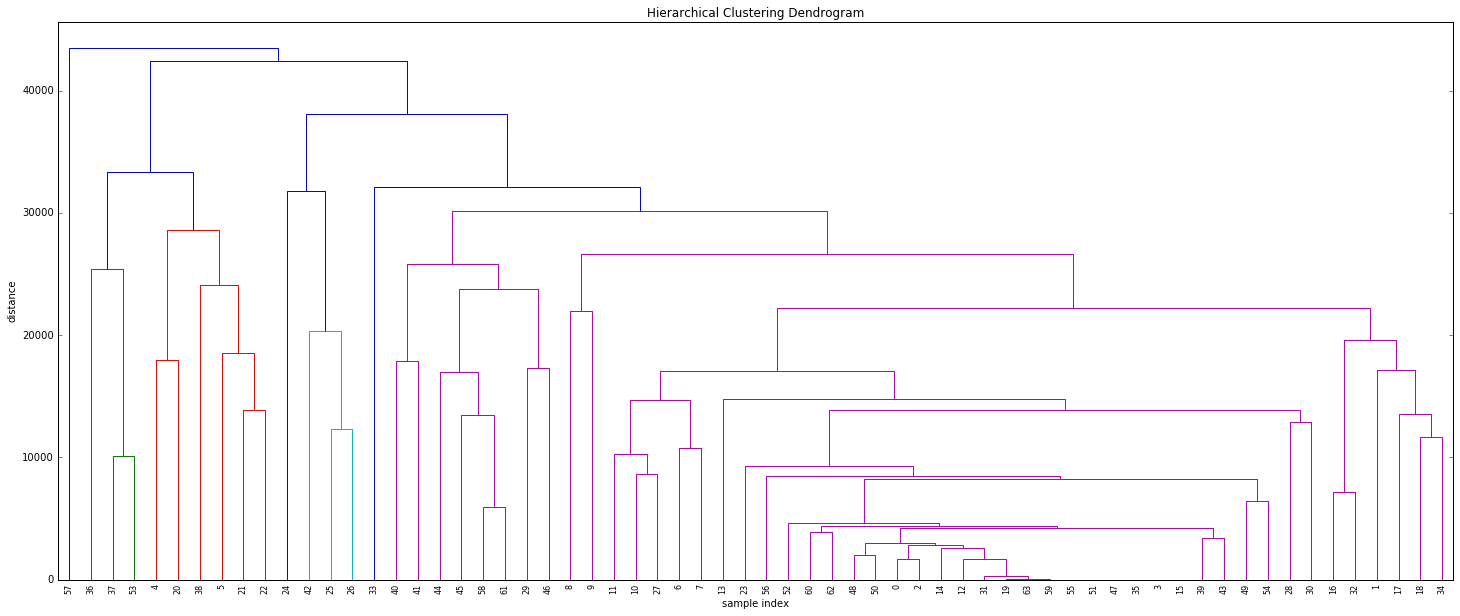

In [89]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

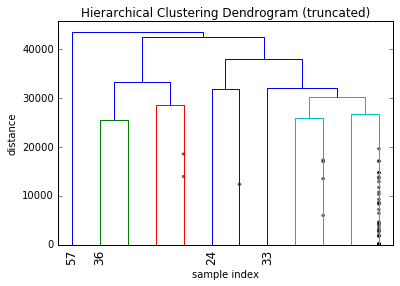

In [90]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [94]:
from scipy.cluster.hierarchy import fcluster
max_d = 50
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([33, 54, 34, 35,  4,  8, 27, 28, 22, 23, 24, 26, 37, 48, 38, 35, 49,
       53, 51, 35,  5,  6,  7, 45, 13, 10, 11, 25, 46, 20, 47, 36, 50, 55,
       52, 35,  3,  1,  9, 39, 14, 15, 12, 40, 19, 18, 21, 35, 31, 42, 32,
       35, 41,  2, 43, 35, 44, 56, 16, 35, 29, 17, 30, 35])